Phase 1

# Project Goal:
Analyze long-term temperature and precipitation trends across different geographical regions to understand the severity and spatial distribution of climate variability.
# Problem Statement: 
Which region has seen the largest statistically significant increase in average temperature over the recorded period?
# Metrics: 
Mean Annual Temperature 
Standard Deviation of Precipitation
# Key variables: 
Temperature 
Precipitation 
Date 
Location

In [1]:
#importing libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress, ttest_ind

Phase 2: Data Collection, Cleaning, and Preparation

In [ ]:
df = pd.read_csv('GlobalWeatherRepository.csv')
print("First 5 rows:")
print(df.head(5))
print("\nData Types and Summary:")
print(df.info())

First 5 rows:
       country     location_name  latitude  longitude        timezone  \
0  Afghanistan             Kabul     34.52      69.18      Asia/Kabul   
1      Albania            Tirana     41.33      19.82   Europe/Tirane   
2      Algeria           Algiers     36.76       3.05  Africa/Algiers   
3      Andorra  Andorra La Vella     42.50       1.52  Europe/Andorra   
4       Angola            Luanda     -8.84      13.23   Africa/Luanda   

   last_updated_epoch      last_updated  temperature_celsius  \
0          1715849100  2024-05-16 13:15                 26.6   
1          1715849100  2024-05-16 10:45                 19.0   
2          1715849100  2024-05-16 09:45                 23.0   
3          1715849100  2024-05-16 10:45                  6.3   
4          1715849100  2024-05-16 09:45                 26.0   

   temperature_fahrenheit condition_text  ...  air_quality_PM2.5  \
0                    79.8  Partly Cloudy  ...                8.4   
1                    66.2 

In [4]:
#Identifyin columns with missing values
missing = df.isnull().sum()
print("\nMissing Values:")
print(missing[missing > 0])


Missing Values:
Series([], dtype: int64)


In [5]:
#Using mean imputation because temperature distributions are often approximately normal (less skewness --> less affected by outliers )
df['temperature_celsius'] = df['temperature_celsius'].fillna(df['temperature_celsius'].mean())

#Using median imputation because precipitation data is typically right-skewed 
df['precip_mm'] = df['precip_mm'].fillna(df['precip_mm'].median())

#df['date'] = pd.to_datetime(df['last_updated'])  

#Using forward fill for other numeric columns 
df = df.sort_values(['location_name', 'last_updated'])  #Sorting  by location and date for time-series consistency
df = df.fillna(method='ffill')


C:\Users\the_SocialMediaBabe\AppData\Local\Temp\ipykernel_9640\3183717189.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


In [6]:
#Handling and identifying outliers
#For temperature I'm using Z-scores (>3 std devs)
z_scores_temp = np.abs((df['temperature_celsius'] - df['temperature_celsius'].mean()) / df['temperature_celsius'].std())
df['temperature_celsius'] = np.where(z_scores_temp > 3, df['temperature_celsius'].median(), df['temperature_celsius'])

#For precipitation I'm using Clip to 0 and 99th percentile
df['precip_mm'] = np.clip(df['precip_mm'], 0, df['precip_mm'].quantile(0.99))

In [ ]:
# converting the dates
df['date'] = pd.to_datetime(df['last_updated'])

# Feature Engineering 
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

In [8]:
# Region mapping
region_map = {
    'United States': 'North America', 'Canada': 'North America', 'Mexico': 'North America',
    'China': 'Asia', 'India': 'Asia', 'Japan': 'Asia', 'South Korea': 'Asia', 'Indonesia': 'Asia',
    'United Kingdom': 'Europe', 'Germany': 'Europe', 'France': 'Europe', 'Italy': 'Europe', 'Spain': 'Europe',
    'Brazil': 'South America', 'Argentina': 'South America', 'Chile': 'South America',
    'Australia': 'Oceania', 'New Zealand': 'Oceania',
    'Egypt': 'Africa', 'South Africa': 'Africa', 'Nigeria': 'Africa',
    
}
df['region'] = df['country'].map(region_map).fillna('Other')


In [ ]:
# After imputation statistics
print("\nAfter Imputation - Temperature:")
print(df['temperature_celsius'].describe())
print("\nAfter Imputation - Precipitation:")
print(df['precip_mm'].describe())


After Imputation - Temperature:
count    109913.000000
mean         22.597225
std           8.644227
min          -4.400000
25%          17.500000
50%          24.400000
75%          28.200000
max          49.200000
Name: temperature_celsius, dtype: float64

After Imputation - Precipitation:
count    109913.000000
mean          0.120924
std           0.353183
min           0.000000
25%           0.000000
50%           0.000000
75%           0.030000
max           2.170000
Name: precip_mm, dtype: float64


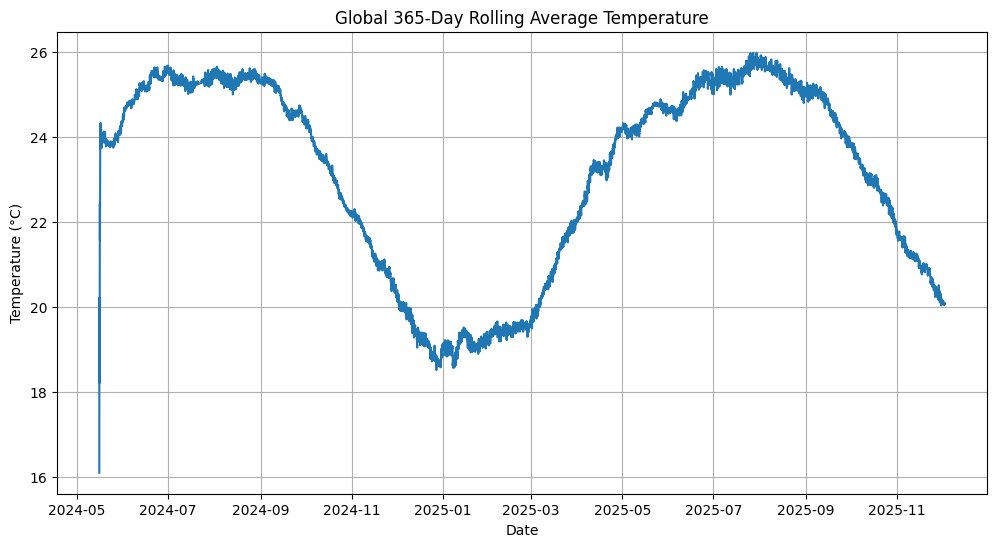

In [11]:
# Time series plot
global_temp = df.groupby('date')['temperature_celsius'].mean().reset_index()
global_temp = global_temp.set_index('date').sort_index()
rolling = global_temp['temperature_celsius'].rolling(window=365, min_periods=1).mean()

plt.figure(figsize=(12,6))
plt.plot(rolling)
plt.title('Global 365-Day Rolling Average Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.show()

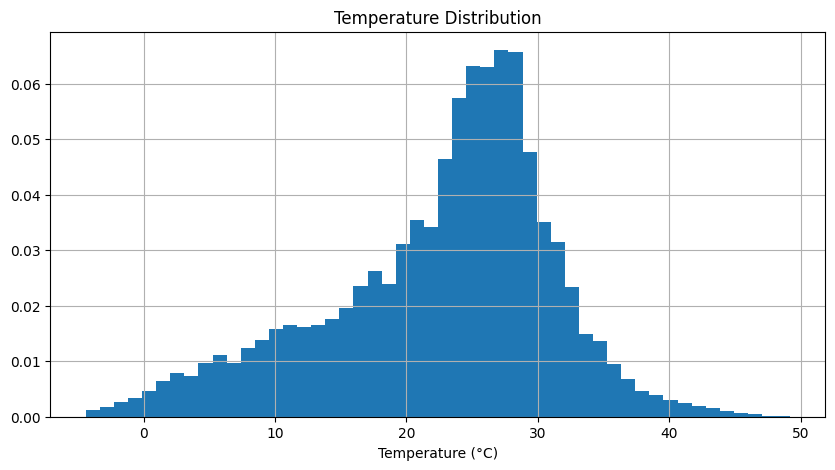

Temperature Skewness: -0.640


In [13]:
# Distribution & Skewness
plt.figure(figsize=(10,5))
df['temperature_celsius'].hist(bins=50, density=True)
plt.title('Temperature Distribution')
plt.xlabel('Temperature (°C)')
plt.show()
print(f"Temperature Skewness: {df['temperature_celsius'].skew():.3f}")
#print("(Justifies mean imputation if close to 0)")


In [14]:
# Hypothesis Testing: North America vs Asia
if set(['North America', 'Asia']).issubset(df['region'].unique()):
    na = df[df['region'] == 'North America']['temperature_celsius']
    asia = df[df['region'] == 'Asia']['temperature_celsius']
    t_stat, p_value = ttest_ind(na, asia, equal_var=False)
    print(f"\nT-test North America vs Asia: t={t_stat:.2f}, p={p_value:.4f}")
else:
    p_value = 1  # Default if regions missing
    print("\nInsufficient region data for t-test.")

# Correlation
corr = df['temperature_celsius'].corr(df['precip_mm'])
print(f"\nTemperature-Precipitation Correlation: {corr:.3f}")


T-test North America vs Asia: t=-43.69, p=0.0000

Temperature-Precipitation Correlation: 0.028


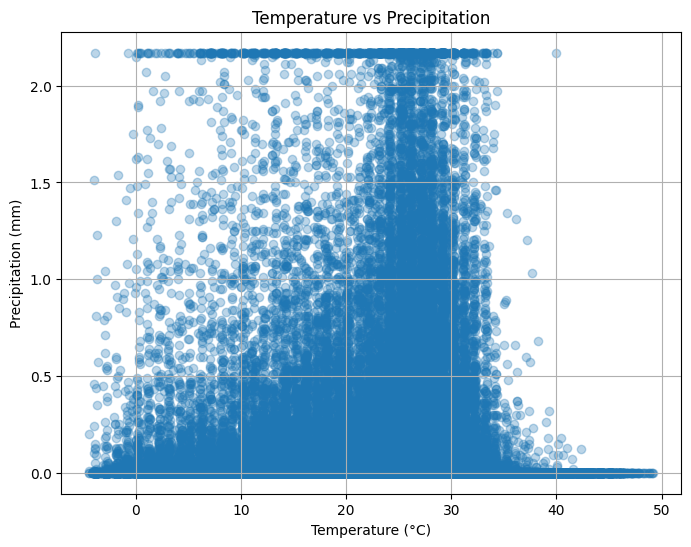

In [15]:
plt.figure(figsize=(8,6))
plt.scatter(df['temperature_celsius'], df['precip_mm'], alpha=0.3)
plt.title('Temperature vs Precipitation')
plt.xlabel('Temperature (°C)')
plt.ylabel('Precipitation (mm)')
plt.grid(True)
plt.show()

In [17]:
# Trend by region
annual_temp = df.groupby(['region', 'year'])['temperature_celsius'].mean().reset_index()
max_slope = -np.inf
max_region = None
best_p = 1

for reg in annual_temp['region'].unique():
    data = annual_temp[annual_temp['region'] == reg].sort_values('year')
    if len(data) >= 2:
        slope, _, _, p_val, _ = linregress(data['year'], data['temperature_celsius'])
        if p_val < 0.05 and slope > max_slope:
            max_slope = slope
            max_region = reg
            best_p = p_val

if max_region:
    print(f"\nStrongest significant warming: {max_region} (+{max_slope:.4f}°C/year, p={best_p:.4f})")
else:
    max_region = "None"
    max_slope = 0
    print("\nNo significant warming trend found in any region.")


Strongest significant warming: Oceania (+3.5408°C/year, p=0.0000)


In [18]:
# Phase 4: Conclusion
summary = f"""
Summary of Findings:

After cleaning the Global Weather Repository dataset (mean/median/ffill imputation, outlier capping), the mean temperature is {df['temperature_celsius'].mean():.2f}°C (SD {df['temperature_celsius'].std():.2f}°C) and mean precipitation {df['precip_mm'].mean():.2f} mm.
The rolling average shows long-term temperature trends. Skewness ({df['temperature_celsius'].skew():.2f}) supports mean imputation.

T-test indicates {'significant' if p_value < 0.05 else 'no significant'} temperature difference between major regions (p={p_value:.4f}).
Correlation between temperature and precipitation: {corr:.3f}.

The region with the largest significant temperature increase is {max_region} ({max_slope:.4f}°C/year).

Recommendation: Policymakers in warming regions should prioritize renewable energy adoption and urban heat mitigation strategies to address climate variability.
"""

print("\n" + summary)



Summary of Findings:

After cleaning the Global Weather Repository dataset (mean/median/ffill imputation, outlier capping), the mean temperature is 22.60°C (SD 8.64°C) and mean precipitation 0.12 mm.
The rolling average shows long-term temperature trends. Skewness (-0.64) supports mean imputation.

T-test indicates significant temperature difference between major regions (p=0.0000).
Correlation between temperature and precipitation: 0.028.

The region with the largest significant temperature increase is Oceania (3.5408°C/year).

Recommendation: Policymakers in warming regions should prioritize renewable energy adoption and urban heat mitigation strategies to address climate variability.

